# EE5179- DeepLearning For Imaging

**Assignment-3** 

**Name: Sapna R**

**Roll no:BS20B032**

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [2]:
train_data=datasets.MNIST(root='./',train=True,download=True)
test_data=datasets.MNIST(root='./',train=False,download=True)
X_train=np.zeros((len(train_data),28,28))
y_train=np.zeros((len(train_data),10))

for i in range(len(train_data)):
    X_train[i]=np.array(list(train_data.__getitem__(i))[0])
    y_train[i][list(train_data.__getitem__(i))[1]]=1
X_test=np.zeros((len(test_data),28,28))
y_test=np.zeros((len(test_data),10))
for i in range(len(test_data)):
    X_test[i]=np.array(list(test_data.__getitem__(i))[0])
    y_test[i][list(test_data.__getitem__(i))[1]]=1

In [3]:
#import torch

def pca(X,k):
    X_mean=torch.mean(X,dim=0)
    X_centered=X-X_mean
    #print(X_mean.shape)
    covariance_matrix=torch.mm(X_centered.t(),X_centered)/(X_centered.shape[0])
    eigenvalues,eigenvectors=torch.linalg.eig(covariance_matrix)
    sorted_indices=torch.argsort(eigenvalues.real,descending=True)
    eigenvectors=eigenvectors[:,sorted_indices].real
    principal_components=eigenvectors[:,:k]
    #print(principal_components.shape)
    y_pca=(torch.mm(X_centered,principal_components.real))
    X_pca=torch.mm(y_pca,principal_components.real.t())
    return X_pca+X_mean,torch.sum(eigenvalues[k:]).real

def pca_test(X,X_test,k):
    X_mean=torch.mean(X,dim=0)
    X_centered=X-X_mean
    #print(X_mean.shape)
    covariance_matrix=torch.mm(X_centered.t(),X_centered)/(X_centered.shape[0])
    eigenvalues,eigenvectors=torch.linalg.eig(covariance_matrix)
    sorted_indices=torch.argsort(eigenvalues.real,descending=True)
    eigenvectors=eigenvectors[:,sorted_indices].real
    principal_components=eigenvectors[:,:k]
    #print(principal_components.shape)
    y_pca=(torch.mm(X_test-torch.mean(X_test,dim=0),principal_components.real))
    X_pca=torch.mm(y_pca,principal_components.real.t())
    return X_pca+torch.mean(X_test,dim=0)




In [4]:
X_train_tensor=torch.tensor(X_train/255)
X_train_tensor=X_train_tensor.reshape((X_train_tensor.shape[0],X_train_tensor.shape[1]*X_train_tensor.shape[2]))
X_hat_train,e_hat=pca(X_train_tensor,30)

X_hat_train=X_hat_train.reshape(X_train.shape)


X_test_tensor=torch.tensor(X_test/255)
X_test_tensor=X_test_tensor.reshape((X_test_tensor.shape[0],X_test_tensor.shape[1]*X_test_tensor.shape[2]))
X_hat_test=pca_test(X_train_tensor,X_test_tensor,30)

X_hat_test=X_hat_test.reshape(X_test.shape)




#X_hat_train = (X_hat_train - X_hat_train.min()) / (X_hat_train.max() - X_hat_train.min())
#plt.imshow(X_hat_train[1])

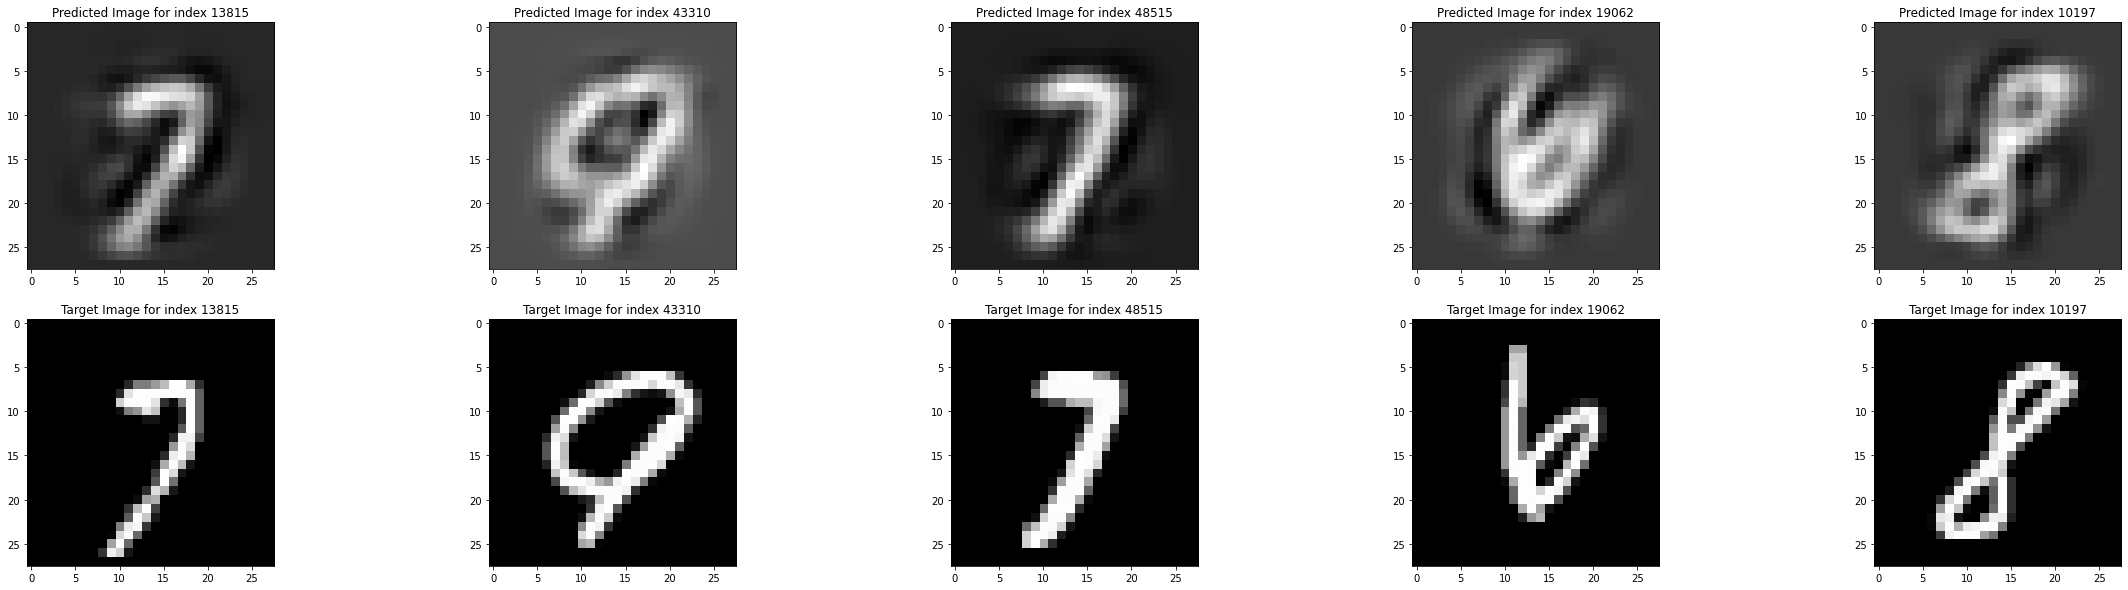

In [5]:
indices=np.random.randint(0,X_train.shape[0],10)
fig,axs=plt.subplots(2,5,figsize=(40,10))
for i in range(5):
    axs[0][i].imshow(X_hat_train[indices[i]],cmap='gray')
    axs[0][i].set_title(f'Predicted Image for index {indices[i]}')
    axs[1][i].imshow(X_train[indices[i]],cmap='gray')
    axs[1][i].set_title(f'Target Image for index {indices[i]}')

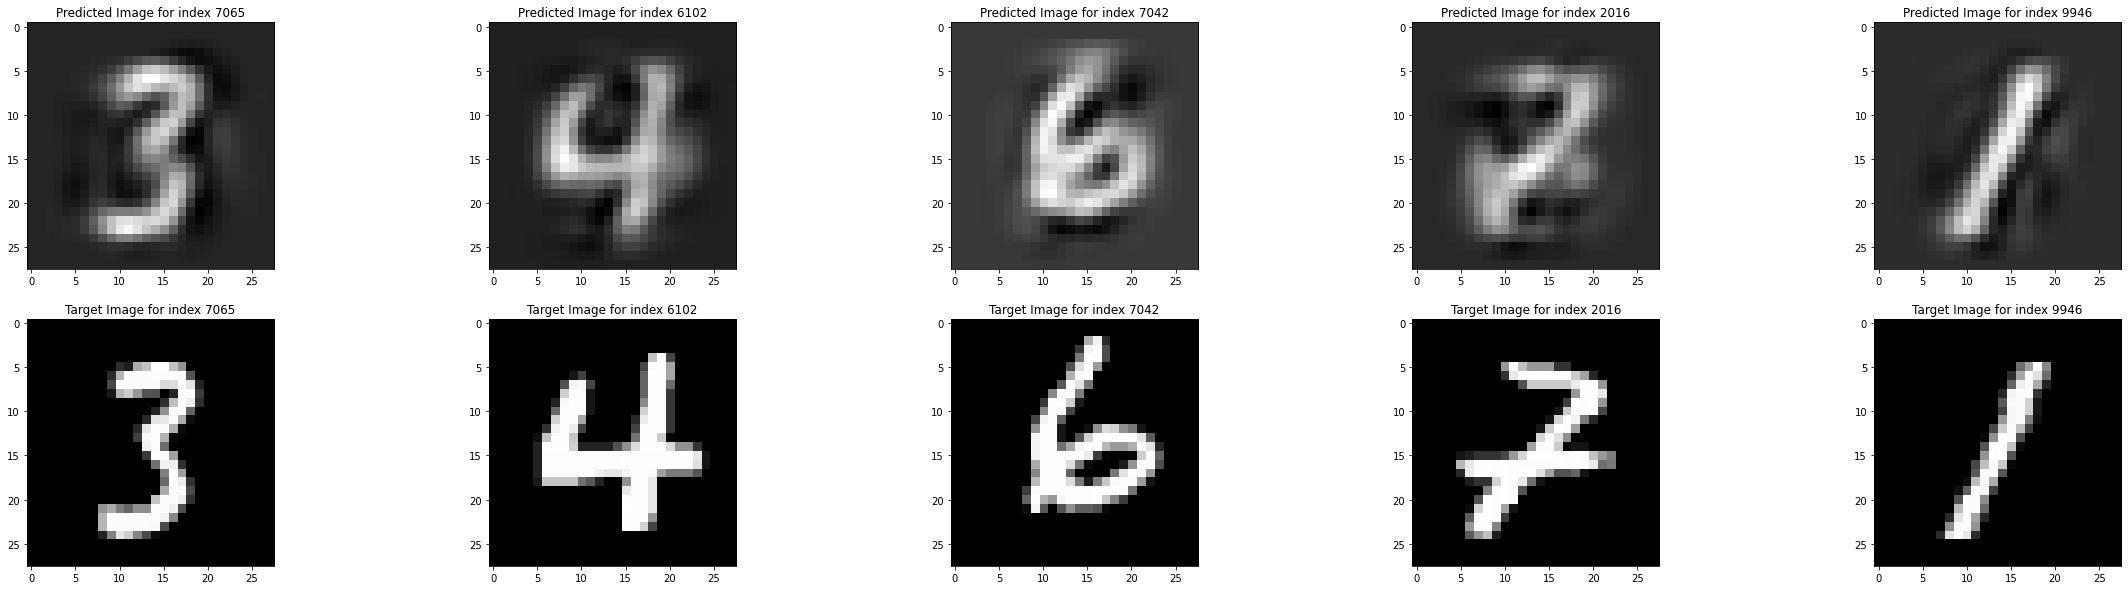

In [6]:
indices=np.random.randint(0,X_test.shape[0],10)
fig,axs=plt.subplots(2,5,figsize=(40,10))
for i in range(5):
    axs[0][i].imshow(X_hat_test[indices[i]],cmap='gray')
    axs[0][i].set_title(f'Predicted Image for index {indices[i]}')
    axs[1][i].imshow(X_test[indices[i]],cmap='gray')
    axs[1][i].set_title(f'Target Image for index {indices[i]}')

In [7]:
class MLP_AE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim1=512, hidden_dim2=256, hidden_dim3=128,latent_dim=30,hidden_dim4=128,
        hidden_dim5=256,output_dim=784):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        #c_hid = base_channel_size
        self.net = nn.Sequential(nn.Linear(input_dim,hidden_dim1),
        nn.ReLU(),nn.Linear(hidden_dim1,hidden_dim2),
        nn.ReLU(),nn.Linear(hidden_dim2,hidden_dim3),
        nn.ReLU(),nn.Linear(hidden_dim3,latent_dim),
        nn.ReLU(),nn.Linear(latent_dim,hidden_dim4),
        nn.ReLU(),nn.Linear(hidden_dim4,hidden_dim5),
        nn.ReLU(),nn.Linear(hidden_dim5,output_dim),
       )# Fill your model code here)

    def forward(self, x):
        return self.net(x)

In [8]:
def train_model(model, X_train,y_train, criterion, optimizer, num_epochs=10,batch_size=64, device='cpu'):
    """X_train=X[:50000]
    y_train=y[:50000]
    X_test=X[50000:]
    y_test=y[50000:]"""
    dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()
    train_error=[]
    test_error=[]

    updates=0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            
            #print(train_loss)
                
            # Zero the parameter gradients
            updates+=1
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()



        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

    print('Training complete.')
    return model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
learning_rate = 0.01
num_epochs = 15

model = MLP_AE().to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_forward=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
print(X_train_forward.shape)


(60000, 784)


In [10]:
model=train_model(model, X_train_forward/255,X_train_forward/255, criterion, optimizer, num_epochs=15, device=device)

Epoch [1/15], Loss: 0.0520
Epoch [2/15], Loss: 0.0443
Epoch [3/15], Loss: 0.0434
Epoch [4/15], Loss: 0.0431
Epoch [5/15], Loss: 0.0429
Epoch [6/15], Loss: 0.0428
Epoch [7/15], Loss: 0.0427
Epoch [8/15], Loss: 0.0426
Epoch [9/15], Loss: 0.0427
Epoch [10/15], Loss: 0.0424
Epoch [11/15], Loss: 0.0424
Epoch [12/15], Loss: 0.0424
Epoch [13/15], Loss: 0.0424
Epoch [14/15], Loss: 0.0424
Epoch [15/15], Loss: 0.0424
Training complete.


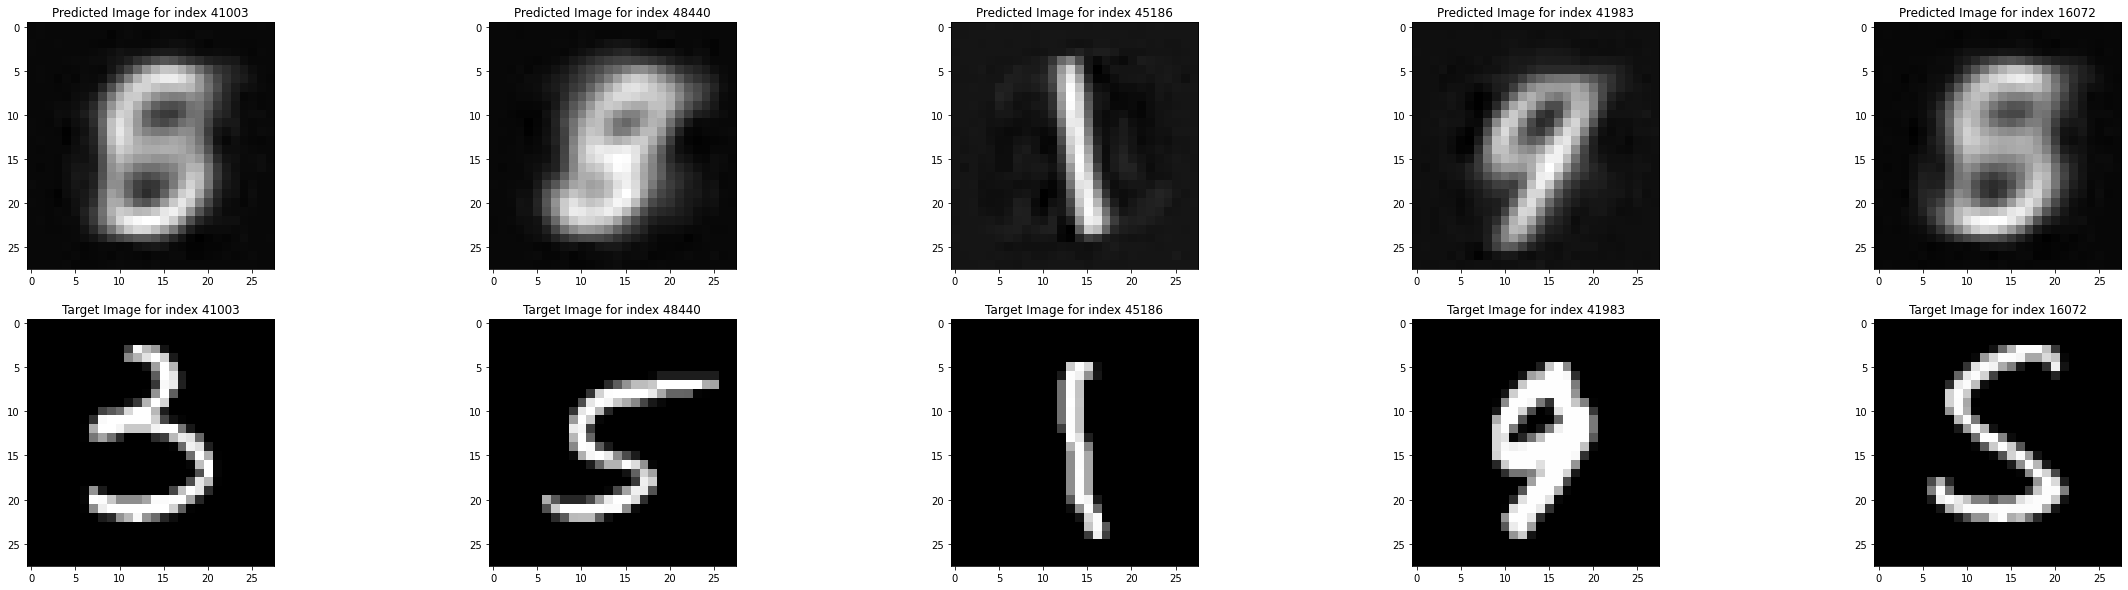

In [11]:
X_hat_train_mlp = model(torch.tensor(X_train_forward/255).float()).reshape(X_train.shape).detach().numpy()

indices=np.random.randint(0,X_train.shape[0],10)
fig,axs=plt.subplots(2,5,figsize=(40,10))
for i in range(5):
    axs[0][i].imshow(X_hat_train_mlp[indices[i]],cmap='gray')
    axs[0][i].set_title(f'Predicted Image for index {indices[i]}')
    axs[1][i].imshow(X_train[indices[i]],cmap='gray')
    axs[1][i].set_title(f'Target Image for index {indices[i]}')

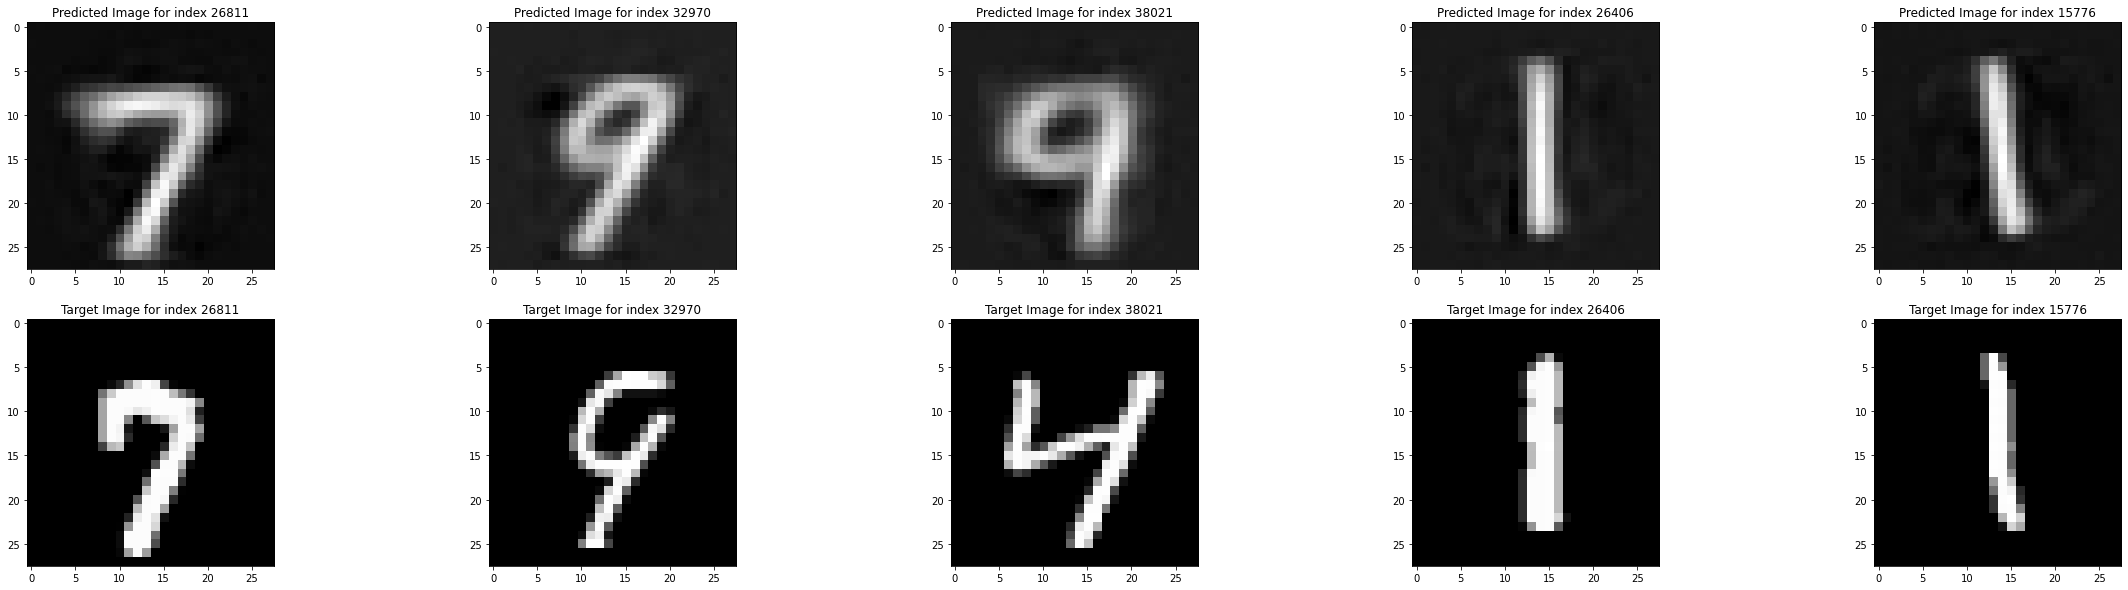

In [12]:
X_test_forward=X_test.reshape((X_test.shape[0],X_train.shape[1]*X_train.shape[2]))

X_hat_test_mlp = model(torch.tensor(X_test_forward/255).float()).reshape(X_test.shape).detach().numpy()

indices=np.random.randint(0,X_train.shape[0],10)
fig,axs=plt.subplots(2,5,figsize=(40,10))
for i in range(5):
    axs[0][i].imshow(X_hat_train_mlp[indices[i]],cmap='gray')
    axs[0][i].set_title(f'Predicted Image for index {indices[i]}')
    axs[1][i].imshow(X_train[indices[i]],cmap='gray')
    axs[1][i].set_title(f'Target Image for index {indices[i]}')

In [13]:
mse_pca=torch.sum(torch.square(torch.tensor(X_train/255)-X_hat_train))/X_train.shape[0]
mse_pca_test=torch.sum(torch.square(torch.tensor(X_test/255)-X_hat_test))/X_test.shape[0]

mse_mlp=torch.sum(torch.square(torch.tensor(X_train/255)-X_hat_train_mlp))/X_train.shape[0]
mse_mlp_test=torch.sum(torch.square(torch.tensor(X_test/255)-X_hat_test_mlp))/X_test.shape[0]


In [14]:
np.max(X_train)

255.0

In [15]:
print(f'The training reconstruction MSE loss from pca is {mse_pca}')
print(f'The testing reconstruction MSE loss from pca is {mse_pca_test}')

print(f'The training reconstruction MSE loss from MLP is {mse_mlp}')
print(f'The testing reconstruction MSE loss from MLP is {mse_mlp_test}')

The training reconstruction MSE loss from pca is 14.207105032565853
The testing reconstruction MSE loss from pca is 13.863155354676108
The training reconstruction MSE loss from MLP is 32.91339130999467
The testing reconstruction MSE loss from MLP is 32.92179261723914


2.

___

In [16]:
class MLP_standard(nn.Module):
    def __init__(self, input_dim=784,hidden_dim1=64,output_dim=784):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        #c_hid = base_channel_size
        self.net = nn.Sequential(nn.Linear(input_dim,hidden_dim1),
        nn.ReLU(),nn.Linear(hidden_dim1,output_dim),
       )# Fill your model code here)

    def forward(self, x):
        return self.net(x)

In [17]:
model1=MLP_standard()
model2=MLP_standard(hidden_dim1=128)

model3=MLP_standard(hidden_dim1=256)


In [18]:
(X_train_forward/255).max()

1.0

In [19]:

optimizer = optim.Adam(model1.parameters(), lr=0.01)
criterion = nn.MSELoss()

model1=train_model(model1, X_train_forward/255,X_train_forward/255, criterion, optimizer,batch_size=64, num_epochs=15, device=device)


Epoch [1/15], Loss: 0.0477
Epoch [2/15], Loss: 0.0458
Epoch [3/15], Loss: 0.0458
Epoch [4/15], Loss: 0.0458
Epoch [5/15], Loss: 0.0458
Epoch [6/15], Loss: 0.0458
Epoch [7/15], Loss: 0.0458
Epoch [8/15], Loss: 0.0458
Epoch [9/15], Loss: 0.0458
Epoch [10/15], Loss: 0.0459
Epoch [11/15], Loss: 0.0458
Epoch [12/15], Loss: 0.0458
Epoch [13/15], Loss: 0.0458
Epoch [14/15], Loss: 0.0458
Epoch [15/15], Loss: 0.0458
Training complete.


In [20]:
optimizer = optim.Adam(model2.parameters(), lr=0.01)
criterion = nn.MSELoss()

model2=train_model(model2, X_train_forward/255,X_train_forward/255, criterion, optimizer,batch_size=64, num_epochs=15, device=device)


Epoch [1/15], Loss: 0.0303
Epoch [2/15], Loss: 0.0273
Epoch [3/15], Loss: 0.0269
Epoch [4/15], Loss: 0.0267
Epoch [5/15], Loss: 0.0266
Epoch [6/15], Loss: 0.0266
Epoch [7/15], Loss: 0.0266
Epoch [8/15], Loss: 0.0266
Epoch [9/15], Loss: 0.0267
Epoch [10/15], Loss: 0.0266
Epoch [11/15], Loss: 0.0267
Epoch [12/15], Loss: 0.0267
Epoch [13/15], Loss: 0.0266
Epoch [14/15], Loss: 0.0267
Epoch [15/15], Loss: 0.0266
Training complete.


In [21]:
optimizer = optim.Adam(model3.parameters(), lr=0.01)
criterion = nn.MSELoss()

model3=train_model(model3, X_train_forward/255,X_train_forward/255, criterion, optimizer,batch_size=64, num_epochs=15, device=device)


Epoch [1/15], Loss: 0.0506
Epoch [2/15], Loss: 0.0490
Epoch [3/15], Loss: 0.0490
Epoch [4/15], Loss: 0.0489
Epoch [5/15], Loss: 0.0490
Epoch [6/15], Loss: 0.0490
Epoch [7/15], Loss: 0.0490
Epoch [8/15], Loss: 0.0490
Epoch [9/15], Loss: 0.0489
Epoch [10/15], Loss: 0.0490
Epoch [11/15], Loss: 0.0489
Epoch [12/15], Loss: 0.0490
Epoch [13/15], Loss: 0.0490
Epoch [14/15], Loss: 0.0490
Epoch [15/15], Loss: 0.0489
Training complete.


Text(0.5, 1.0, 'x=256')

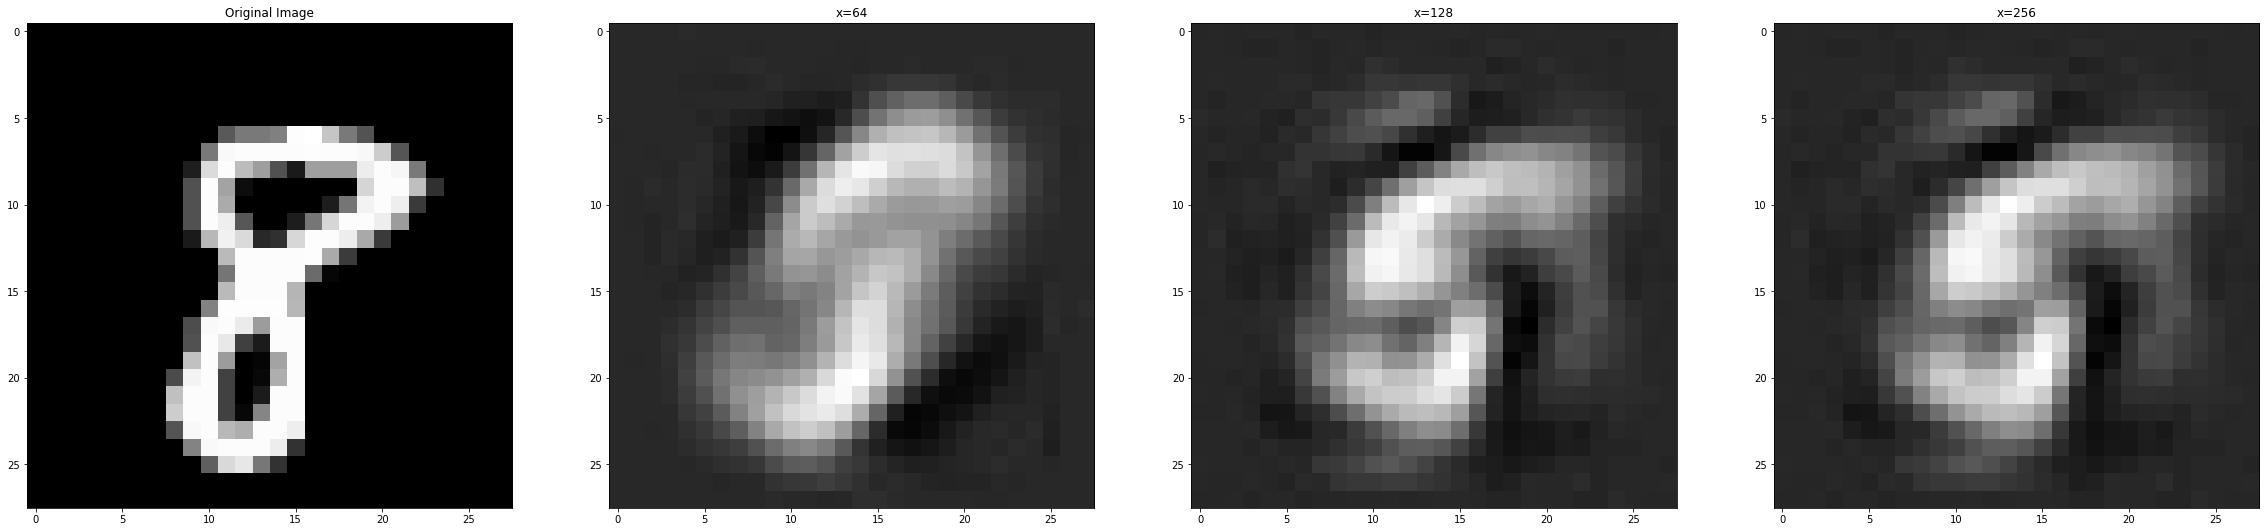

In [22]:
X_hat_test_mlp_1 = model1(torch.tensor(X_test_forward/255).float()).reshape(X_test.shape).detach().numpy()
#X_hat_test_mlp_1=(X_hat_test_mlp_1-X_hat_test_mlp_1.min())/(X_hat_test_mlp_1.max()-X_hat_test_mlp_1.min())
X_hat_test_mlp_2 = model2(torch.tensor(X_test_forward/255).float()).reshape(X_test.shape).detach().numpy()
#X_hat_test_mlp_2=(X_hat_test_mlp_2-X_hat_test_mlp_2.min())/(X_hat_test_mlp_2.max()-X_hat_test_mlp_2.min())

X_hat_test_mlp_3 = model2(torch.tensor(X_test_forward/255).float()).reshape(X_test.shape).detach().numpy()
#X_hat_test_mlp_3=(X_hat_test_mlp_3-X_hat_test_mlp_3.min())/(X_hat_test_mlp_3.max()-X_hat_test_mlp_3.min())

indices=np.random.randint(0,X_test.shape[0],1)
fig,axs=plt.subplots(1,4,figsize=(40,10))
#for i in range(5):
axs[0].imshow(X_train[indices[0]],cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(X_hat_test_mlp_1[indices[0]],cmap='gray')
axs[1].set_title(f'x=64')
axs[2].imshow(X_hat_test_mlp_2[indices[0]],cmap='gray')
axs[2].set_title(f'x=128')
axs[3].imshow(X_hat_test_mlp_3[indices[0]],cmap='gray')
axs[3].set_title(f'x=256')


The reconstructions of a randomly sampled test image has come out to resembling a different digit/superposition of different digits in most cases. This possibly indicates that the manifolds of different variations of the same digit might be more close  to the manifold representations of  other digits in the manifold than its own self

Text(0.5, 1.0, 'x=256')

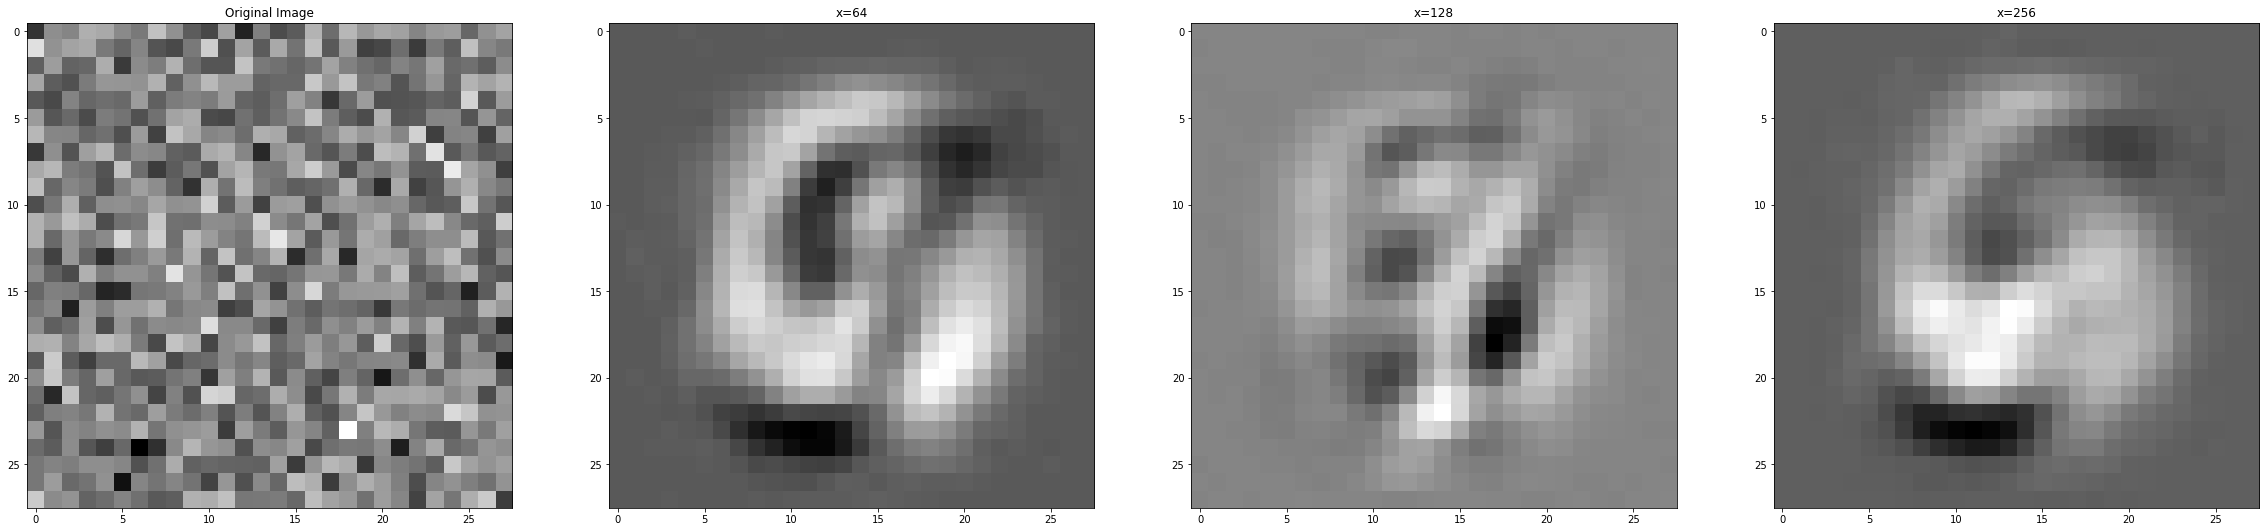

In [23]:
X_random=np.random.normal(128,1,size=(1,784))
X_random_reshaped=X_random.reshape((28,28))
with torch.no_grad():
    X_1=model1(torch.tensor(X_random/255).float()).reshape(X_random_reshaped.shape).numpy()
    X_2=model2(torch.tensor(X_random/255).float()).reshape(X_random_reshaped.shape).numpy()
    X_3=model3(torch.tensor(X_random/255).float()).reshape(X_random_reshaped.shape).numpy()
fig,axs=plt.subplots(1,4,figsize=(40,10))

axs[0].imshow(X_random_reshaped,cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(X_1,cmap='gray')
axs[1].set_title(f'x=64')
axs[2].imshow(X_2,cmap='gray')
axs[2].set_title(f'x=128')
axs[3].imshow(X_3,cmap='gray')
axs[3].set_title(f'x=256')



The reconstruction for a non digit image/random image is an output with which looks like the superposition of multiple digits for values of x=[64,128,256]

Text(0.5, 0.98, 'Weights to hidden layer')

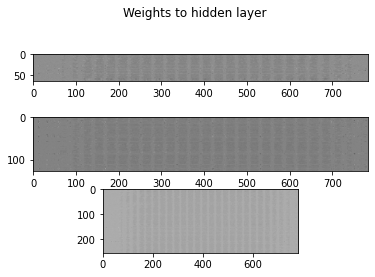

In [24]:
input_hidden1=model1.net[0].weight.detach().numpy()
input_hidden2=model2.net[0].weight.detach().numpy()
input_hidden3=model3.net[0].weight.detach().numpy()

fig,axs=plt.subplots(3,1)
axs[0].imshow(input_hidden1,cmap='gray')
axs[1].imshow(input_hidden2,cmap='gray')
axs[2].imshow(input_hidden3,cmap='gray')
plt.suptitle('Weights to hidden layer')



Text(0.5, 0.98, 'Weights to Output')

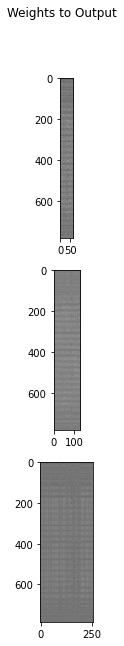

In [25]:
hidden_output1=model1.net[2].weight.detach().numpy()
hidden_output2=model2.net[2].weight.detach().numpy()
hidden_output3=model3.net[2].weight.detach().numpy()

fig,axs=plt.subplots(3,1,figsize=(5,10))
axs[0].imshow(hidden_output1,cmap='gray')
axs[1].imshow(hidden_output2,cmap='gray')
axs[2].imshow(hidden_output3,cmap='gray')
plt.suptitle('Weights to Output')

1. The weights to the hidden layer and output upon visualising depicts striped pattern. This indicates that the input neurons display an alternating pattern in modulating the output of the hidden layer neurons and this applies to the neurons from the hidden ayer to the output layer

3.
___

In [26]:
class MLP_sparse(nn.Module):
    def __init__(self, input_dim=784,hidden_dim1=1500,output_dim=784):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        self.linear1=nn.Linear(input_dim,hidden_dim1)
        self.relu=nn.ReLU()
        self.output=nn.Linear(hidden_dim1,output_dim)

    def forward(self, x):
        z=self.linear1(x)
        h=self.relu(z)
        y=self.output(h)
        return h,y

In [27]:
def train_model(model, X_train,y_train, criterion,l1_lambda, optimizer, num_epochs=10,batch_size=64, device='cpu'):

    dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()
    
    updates=0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            
            #print(train_loss)
                
            # Zero the parameter gradients
            updates+=1
            optimizer.zero_grad()

            # Forward pass
            h,outputs = model(inputs)
            loss = criterion(outputs, labels)+l1_lambda * torch.norm(h, p=1)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()



        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

    print('Training complete.')
    return model

In [28]:
model4=MLP_sparse(hidden_dim1=1000)
criterion = nn.MSELoss()

optimizer = optim.Adam(model4.parameters(), lr=0.05)
l1_lambda=0.001
model4=train_model(model4, X_train_forward/255,X_train_forward/255, criterion, l1_lambda,optimizer,batch_size=64, num_epochs=15, device=device)


Epoch [1/15], Loss: 0.0733
Epoch [2/15], Loss: 0.0678
Epoch [3/15], Loss: 0.0677
Epoch [4/15], Loss: 0.0678
Epoch [5/15], Loss: 0.0677
Epoch [6/15], Loss: 0.0677
Epoch [7/15], Loss: 0.0678
Epoch [8/15], Loss: 0.0677
Epoch [9/15], Loss: 0.0678
Epoch [10/15], Loss: 0.0678
Epoch [11/15], Loss: 0.0677
Epoch [12/15], Loss: 0.0678
Epoch [13/15], Loss: 0.0677
Epoch [14/15], Loss: 0.0678
Epoch [15/15], Loss: 0.0678
Training complete.


In [29]:
model5=MLP_sparse(hidden_dim1=1000)
criterion = nn.MSELoss()

optimizer = optim.Adam(model5.parameters(), lr=0.05)
l1_lambda=0.0001
model5=train_model(model5, X_train_forward/255,X_train_forward/255, criterion, l1_lambda,optimizer,batch_size=64, num_epochs=15, device=device)


Epoch [1/15], Loss: 0.0684
Epoch [2/15], Loss: 0.0677
Epoch [3/15], Loss: 0.0677
Epoch [4/15], Loss: 0.0677
Epoch [5/15], Loss: 0.0678
Epoch [6/15], Loss: 0.0677
Epoch [7/15], Loss: 0.0677
Epoch [8/15], Loss: 0.0678
Epoch [9/15], Loss: 0.0678
Epoch [10/15], Loss: 0.0678
Epoch [11/15], Loss: 0.0678
Epoch [12/15], Loss: 0.0678
Epoch [13/15], Loss: 0.0677
Epoch [14/15], Loss: 0.0678
Epoch [15/15], Loss: 0.0678
Training complete.


In [30]:
model6=MLP_sparse(hidden_dim1=1000)
criterion = nn.MSELoss()

optimizer = optim.Adam(model6.parameters(), lr=0.05)
l1_lambda=0.01
model6=train_model(model6, X_train_forward/255,X_train_forward/255, criterion, l1_lambda,optimizer,batch_size=64, num_epochs=15, device=device)


Epoch [1/15], Loss: 0.1219
Epoch [2/15], Loss: 0.0677
Epoch [3/15], Loss: 0.0678
Epoch [4/15], Loss: 0.0677
Epoch [5/15], Loss: 0.0678
Epoch [6/15], Loss: 0.0678
Epoch [7/15], Loss: 0.0678
Epoch [8/15], Loss: 0.0677
Epoch [9/15], Loss: 0.0678
Epoch [10/15], Loss: 0.0677
Epoch [11/15], Loss: 0.0677
Epoch [12/15], Loss: 0.0677
Epoch [13/15], Loss: 0.0678
Epoch [14/15], Loss: 0.0678
Epoch [15/15], Loss: 0.0678
Training complete.


Text(0.5, 1.0, 'lambda=0.01')

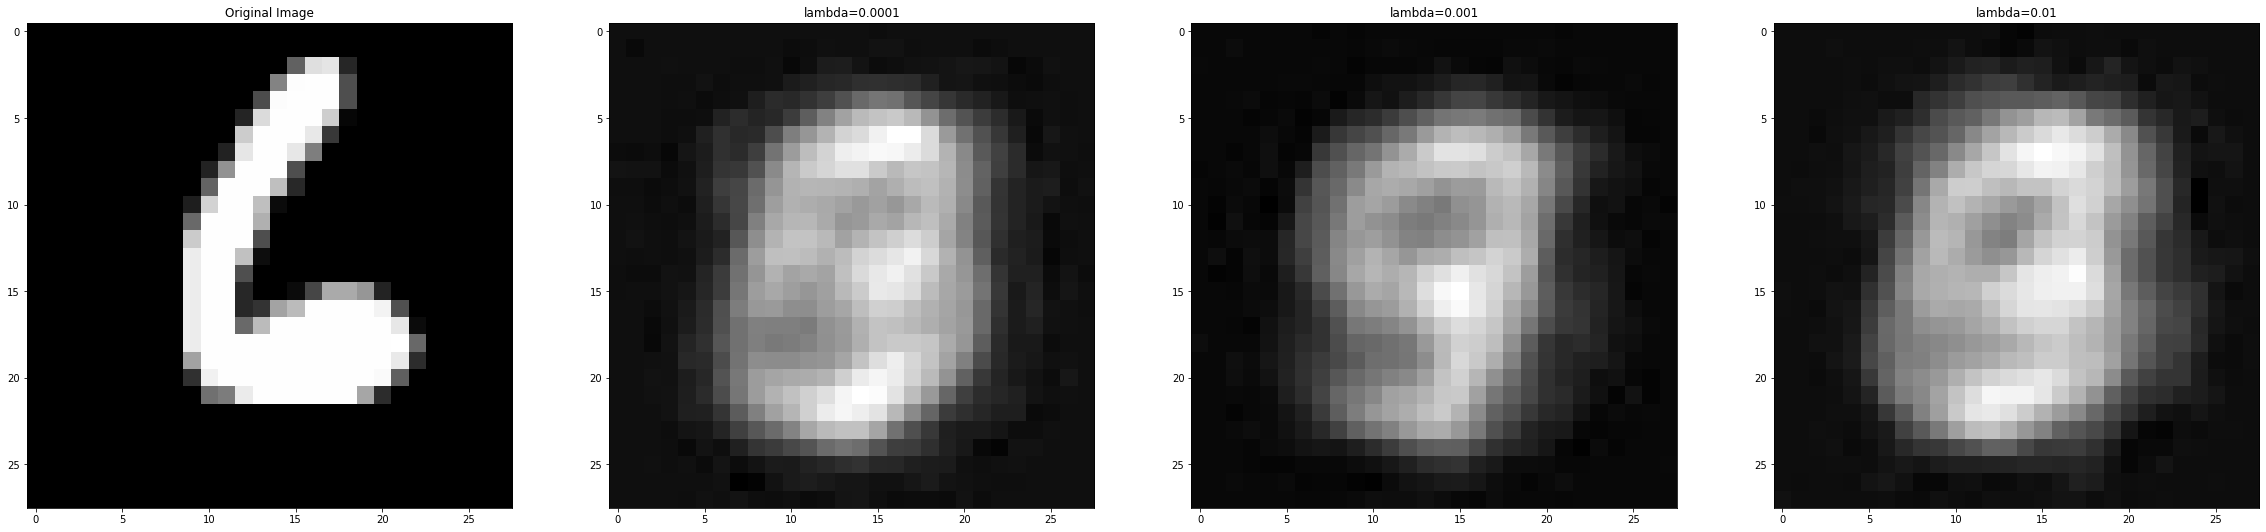

In [31]:
_,X_hat_test_mlp_4 = model4(torch.tensor(X_test_forward/255).float())
X_hat_test_mlp_4=X_hat_test_mlp_4.reshape(X_test.shape).detach().numpy()
#X_hat_test_mlp_1=(X_hat_test_mlp_1-X_hat_test_mlp_1.min())/(X_hat_test_mlp_1.max()-X_hat_test_mlp_1.min())
_,X_hat_test_mlp_5 = model5(torch.tensor(X_test_forward/255).float())
X_hat_test_mlp_5=X_hat_test_mlp_5.reshape(X_test.shape).detach().numpy()
#X_hat_test_mlp_2=(X_hat_test_mlp_2-X_hat_test_mlp_2.min())/(X_hat_test_mlp_2.max()-X_hat_test_mlp_2.min())

_,X_hat_test_mlp_6 = model6(torch.tensor(X_test_forward/255).float())
X_hat_test_mlp_6=X_hat_test_mlp_6.reshape(X_test.shape).detach().numpy()
#X_hat_test_mlp_3=(X_hat_test_mlp_3-X_hat_test_mlp_3.min())/(X_hat_test_mlp_3.max()-X_hat_test_mlp_3.min())

indices=np.random.randint(0,X_test.shape[0],1)
fig,axs=plt.subplots(1,4,figsize=(40,10))
#for i in range(5):
axs[0].imshow(X_train[indices[0]],cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(X_hat_test_mlp_5[indices[0]],cmap='gray')
axs[1].set_title(f'lambda=0.0001')
axs[2].imshow(X_hat_test_mlp_4[indices[0]],cmap='gray')
axs[2].set_title(f'lambda=0.001')
axs[3].imshow(X_hat_test_mlp_6[indices[0]],cmap='gray')
axs[3].set_title(f'lambda=0.01')
